In [1]:
!pip install -q ipython-autotime
%load_ext autotime

time: 142 μs (started: 2025-06-11 05:29:33 +00:00)


In [2]:
!pip install  -U -q transformers trl datasets bitsandbytes peft accelerate
!pip install -q tensorboardX

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pathos 0.3.4 requires dill>=0.4.0, but you have dill 0.3.8 which is incompatible.
pathos 0.3.4 requires multiprocess>=0.70.18, but you have multiprocess 0.70.16 which is incompatible.
time: 1min 42s (started: 2025-06-11 05:29:33 +00:00)


In [4]:
# !pip install -q flash-attn --no-build-isolation

time: 204 μs (started: 2025-06-10 11:02:09 +00:00)


In [3]:
from huggingface_hub import notebook_login

notebook_login()

time: 538 ms (started: 2025-06-11 05:31:16 +00:00)


In [1]:
import torch
from transformers import Idefics3ForConditionalGeneration, AutoProcessor

model_id = "HuggingFaceTB/SmolVLM-Instruct"

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Prepare Fine Tuning Dataset

**We will additionally add system prompt for this specific task**

In [2]:
system_message = """You are an expert document understanding AI specialized in extracting structured data from invoice images. Your task is to accurately extract all required fields from the provided invoice image, following the field definitions and instructions. 
Be precise, robust to layout variations, and handle missing or ambiguous fields gracefully. 
Return the extracted data as a JSON object with the specified keys."""


In [3]:
# base prompt
prompt_a = """
You are an intelligent invoice parser. From the provided invoice imag, extract the following structured information and return it in valid JSON format. 
Follow the descriptions and formatting guidelines for each field exactly. 

Field Descriptions and Format Requirements:

client_name: The full name of the client (person or company) to whom the invoice is issued. Must be a single string without extra labels like "Bill To" or "Client:".
client_address: The complete mailing address of the client. It may span multiple lines. Include line breaks as \n. Remove any label like "Address:" or "Client Address:".
seller_name: The full name of the seller or vendor (person or company) issuing the invoice. A single string only.
seller_address: The full address of the seller. It may span multiple lines. Include line breaks as \n.
invoice_number: A unique identifier for the invoice. Often labeled as "Invoice No.", "Invoice #", or simply "No.". Extract the alphanumeric value exactly.
invoice_date: The date the invoice was issued. Must be in MM/DD/YYYY format. If the original format differs (e.g., DD-MM-YYYY or YYYY/MM/DD), convert it to MM/DD/YYYY.
tax: The tax amount applied on the invoice. Extract only the numeric part (e.g., 809.62) and preserve the original formatting for decimals and thousand separators if present (e.g., 1,234.56 or 809,62).
discount: Any discount applied. Use the same formatting as for tax. If not present, use "".
total: The gross total amount after applying tax and discount. This should reflect the final amount the client has to pay. Maintain the original number formatting (e.g., 8 905,77 or 8,905.77).


Expected JSON Output Format:

{
  "client_name": "",
  "client_address": "",
  "seller_name": "",
  "seller_address": "",
  "invoice_number": "",
  "invoice_date": "",
  "tax": "",
  "discount": "",
  "total": ""
}

Guidelines:
- If any field is missing or not explicitly mentioned in the text, use an empty string ("") as its value.
- Do not halluciante
"""

In [4]:
ls

configs/                                     prepare_invoice_data.py
data/                                        __pycache__/
dynamic_invoice_extraction_prompt.py         pyproject.toml
inference/                                   README.md
invoice-data-extraction-using-smolvlm.ipynb  smolvlm-it-trl-invoice-v3/
invoice_evaluate_response.py                 smolvlm-trl-inovice.ipynb
llm_finetuning/                              test_code.ipynb
llm.py                                       uv.lock
main.py


In [5]:
import os
import requests
import pandas as pd
import json
import yaml

# Configuration
BULK_DATA_PATH = "./data/prepared_invoice_data_batch1_2.csv"
OUTPUT_CSV = "./data/vllm_inference_results.csv"
IMAGE_FOLDER_PATH =  "../batch_1/batch_1/batch1_2/"
# Load bulk data
data = pd.read_csv(BULK_DATA_PATH)
data.head()

,file_name,invoice_no,requested_parameters,requested_data
0,batch1-0500.jpg,34476404,"[""client_address"", ""client_name"", ""discount"", ...","{""client_address"": ""85942 Tucker Plains Apt. 9..."
1,batch1-0501.jpg,18999056,"[""client_address"", ""client_name"", ""discount"", ...","{""client_address"": ""810 Adkins Canyon\nKristin..."
2,batch1-0502.jpg,33289699,"[""client_address"", ""client_name"", ""discount"", ...","{""client_address"": ""USNV Gilbert\nFPO AP 32645..."
3,batch1-0503.jpg,22758345,"[""client_address"", ""client_name"", ""discount"", ...","{""client_address"": ""27910 Lindsey Inlet\nPort ..."
4,batch1-0504.jpg,79036267,"[""client_address"", ""client_name"", ""discount"", ...","{""client_address"": ""26018 Erica Mission Suite ..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   file_name             426 non-null    object
 1   invoice_no            426 non-null    int64 
 2   requested_parameters  426 non-null    object
 3   requested_data        426 non-null    object
dtypes: int64(1), object(3)
memory usage: 13.4+ KB


In [7]:
#load the images
import os

images_paths = []
file_names_lst = []
expected_resp_lst = []

for file in os.listdir(IMAGE_FOLDER_PATH):
    if file not in data['file_name'].tolist():
        continue
    if file.endswith(".jpg"):
        images_paths.append(os.path.join(IMAGE_FOLDER_PATH, file))
        file_names_lst.append(file)
        expected_resp_lst.append(data[data['file_name']==file]["requested_data"].values[0])
    else:
        print(f"Differen then .jpg file here: {file}")
len(images_paths), len(file_names_lst), len(expected_resp_lst)

(425, 425, 425)

In [8]:
# Load processor tokenizer
processor = AutoProcessor.from_pretrained(model_id)

In [9]:
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from transformers.image_utils import load_image
import torch
import pandas as pd


class InvoiceDataset(Dataset):
    def __init__(self, image_paths, file_names, queries, responses, system_prompt, processor):
        self.image_paths = image_paths
        self.file_names = file_names
        self.queries = queries
        self.responses = responses
        self.system_prompt = system_prompt
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        query = self.queries
        label = self.responses[idx]
        file_name = self.file_names[idx]
        
        messages = self.format_data(query, image, label)
        
        return {
            "image": image,
            "messages": messages,
            "response": label,
            "file_name": file_name,
        }
    
    def format_data(self, user_prompt, image, label):
        return [
            {
                "role": "system",
                "content": [{"type": "text", "text": self.system_prompt}],
            },
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": image,
                    },
                    {
                        "type": "text",
                        "text": user_prompt,
                    },
                ],
            },
            {
                "role": "assistant",
                "content": [{"type": "text", "text": label}],
            },
        ]

def custom_collate_fn(batch):
    images = [item["image"] for item in batch]
    messages_list = [item["messages"] for item in batch]
    file_names = [item["file_name"] for item in batch]

    # This list will store the tokenized representations of the *full conversation*
    # which will become our input_ids and labels (after masking)
    input_texts = []
    # This list will store the length of the prompt for each example,
    # so we can mask the labels correctly.
    prompt_lengths = []

    for messages in messages_list:
        # Get the full conversation as a string
        full_conversation_str = processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)
        input_texts.append(full_conversation_str)

        # Get the prompt part of the conversation (everything up to the assistant's first message)
        # We need to make sure the prompt includes the correct tokens that the model expects
        # before generating, which might include special tokens like <|start_header_id|>assistant<|end_header_id|>\n\n
        # The trick is to apply the chat template up to the user's last message,
        # and then manually append the start of the assistant's turn.

        # Find the index of the assistant's first message
        assistant_start_idx = -1
        for i, msg in enumerate(messages):
            if msg["role"] == "assistant":
                assistant_start_idx = i
                break
        
        if assistant_start_idx == -1: # No assistant message, this batch item might be problematic
            # Handle cases where there's no assistant response in the messages.
            # For fine-tuning, you typically expect a full turn.
            # For now, let's assume valid data.
            # If this happens, the prompt length should be the full conversation length
            # and labels will be all -100.
            prompt_str = full_conversation_str # Treat whole thing as prompt
        else:
            # Reconstruct the prompt string up to the start of the assistant's message
            prompt_messages = messages[:assistant_start_idx]
            # Crucially, apply the chat template with add_generation_prompt=True for the prompt part
            # to include the token that indicates the model should start generating an assistant response.
            prompt_str = processor.apply_chat_template(prompt_messages, add_generation_prompt=True, tokenize=False)

        # Tokenize the prompt string to get its length in tokens
        prompt_tokens_len = len(processor.tokenizer(prompt_str, return_tensors="pt").input_ids[0])
        prompt_lengths.append(prompt_tokens_len)


    # Tokenize the full conversations for model inputs
    model_inputs = processor(
        text=input_texts,
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    # Now create the labels
    labels = model_inputs["input_ids"].clone()

    # Mask out tokens belonging to the prompt part
    for i, prompt_len in enumerate(prompt_lengths):
        labels[i, :prompt_len] = -100

    # Also mask padding tokens if they are not already -100 from the prompt masking
    # (padding tokens are typically `pad_token_id` after tokenization)
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # Mask image token IDs in labels if they are not already -100
    # Note: image tokens usually appear in input_ids, not typically in the "label" part
    # but it's good practice to mask them if they somehow end up in the label's expected span.
    # The actual image token ID for SmolVLM might be different, confirm this.
    if "<image>" in processor.tokenizer.additional_special_tokens:
        image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")
        ]
        labels[labels == image_token_id] = -100


    model_inputs["labels"] = labels
    model_inputs["file_names"] = file_names
    model_inputs["return_loss"] = True
    
    # Debug prints!
    # print(f"Batch Size (input_ids): {model_inputs['input_ids'].shape[0]}")
    # if "pixel_values" in model_inputs:
    #      print(f"Batch Size (pixel_values): {model_inputs['pixel_values'].shape[0]}")
    # print(f"Batch Size (labels): {model_inputs['labels'].shape[0]}")

    return model_inputs

def custom_collate_fn_v2(batch):
    images = [item["image"] for item in batch]
    messages_list = [item["messages"] for item in batch]
    file_names = [item["file_name"] for item in batch]

    # This list will store the tokenized representations of the *full conversation*
    input_texts = []
    # This list will store the length of the prompt for each example,
    # so we can mask the labels correctly.
    prompt_lengths = []

    for messages in messages_list:
        # Step 1: Get the full conversation as a string, including system, user, and assistant parts
        # This will be used to generate the input_ids for the model
        full_conversation_str = processor.apply_chat_template(messages, add_generation_prompt=False, tokenize=False)
        input_texts.append(full_conversation_str)

        # Step 2: Determine the length of the prompt part.
        # The prompt for label masking should include everything up to the *beginning* of the assistant's actual text.
        # This means: system prompt + user prompt (including image token placeholder) + assistant's turn-starting tokens.
        
        # Create a message list containing only the system and user messages
        prompt_only_messages = []
        for msg in messages:
            if msg["role"] == "assistant":
                break # Stop when we hit the assistant's message
            prompt_only_messages.append(msg)

        # Apply chat template to ONLY the prompt part.
        # CRUCIALLY, use add_generation_prompt=True here. This will append the specific
        # tokens that signal the start of the assistant's response (e.g., <|start_header_id|>assistant<|end_header_id|>\n\n).
        # These tokens are part of the input and must be masked in the labels.
        prompt_str_for_masking = processor.apply_chat_template(prompt_only_messages, add_generation_prompt=True, tokenize=False)
        
        # Tokenize this prompt string to get its length in tokens
        prompt_tokens_len = len(processor.tokenizer(prompt_str_for_masking, return_tensors="pt").input_ids[0])
        prompt_lengths.append(prompt_tokens_len)

        # --- Debugging prints for each individual sample in the batch ---
        print(f"\n--- Sample Debug ({file_names[messages_list.index(messages)]}) ---")
        print(f"Full conversation string (first 200 chars): {full_conversation_str[:200]}...")
        print(f"Prompt string for masking (first 200 chars): {prompt_str_for_masking[:200]}...")
        print(f"Calculated prompt_tokens_len: {prompt_tokens_len}")
        print(f"Expected start of assistant response in tokens (from prompt string):")
        decoded_prompt_end = processor.decode(processor.tokenizer(prompt_str_for_masking, return_tensors="pt").input_ids[0], skip_special_tokens=False)
        print(f"(last 50 chars)  -> {decoded_prompt_end[-50:]} ") # Show last part of decoded prompt_str

    # Tokenize the full conversations for model inputs
    model_inputs = processor(
        text=input_texts, # Pass the full conversation strings
        images=images,
        return_tensors="pt",
        padding=True,
        truncation=True
    )

    # Now create the labels
    labels = model_inputs["input_ids"].clone()

    # Mask out tokens belonging to the prompt part
    for i, prompt_len in enumerate(prompt_lengths):
        labels[i, :prompt_len] = -100 # Set prompt tokens to -100

    # Also mask padding tokens if they are not already -100
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # Mask image token IDs in labels if they appear
    # The actual image token ID for SmolVLM might be different, confirm this.
    if "<image>" in processor.tokenizer.additional_special_tokens:
        image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]
        labels[labels == image_token_id] = -100 # Mask image token IDs in labels

    model_inputs["labels"] = labels
    model_inputs["file_names"] = file_names
    
    # --- Debug prints for the final batch tensors ---
    print(f"\n--- Final Collated Batch Debug ---")
    print(f"Batch Size (input_ids): {model_inputs['input_ids'].shape[0]}")
    if "pixel_values" in model_inputs:
         print(f"Batch Size (pixel_values): {model_inputs['pixel_values'].shape[0]}")
    print(f"Batch Size (labels): {model_inputs['labels'].shape[0]}")
    print(f"Max sequence length: {model_inputs['input_ids'].shape[1]}")

    # Decode final labels for first sample in batch for inspection
    print("\nDecoded Labels (first sample in batch):")
    # Replace -100 with pad_token_id for decoding, then filter out padding
    decoded_labels_tokens = model_inputs['labels'][0].clone()
    decoded_labels_tokens[decoded_labels_tokens == -100] = processor.tokenizer.pad_token_id
    decoded_labels_tokens = decoded_labels_tokens[decoded_labels_tokens != processor.tokenizer.pad_token_id]
    
    if decoded_labels_tokens.numel() > 0:
        print(processor.decode(decoded_labels_tokens, skip_special_tokens=True))
    else:
        print("(No unmasked label tokens found - this would be a major problem!)")
    
    return model_inputs

# Initialize dataset and dataloader
dataset = InvoiceDataset(images_paths, file_names_lst, prompt_a, expected_resp_lst, system_message,  processor)
dataloader = DataLoader(dataset, batch_size=2, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)


In [10]:
total_samples = len(dataset)
train_ratio = 0.9
val_ratio = 1 - train_ratio
train_size = int(train_ratio * total_samples)
val_size = total_samples - train_size
generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=2, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)


### Inspecting Dataset

In [90]:

import random

batch = next(iter(dataloader))
print(batch.keys())  # Displays the keys in the batch dictionary
for key, value in batch.items():
    if (key == 'return_loss'):
        continue
    if (key == 'file_names') :
        print(f"{key}: shape = {len(value)}, dtype = {type(value)}, values: {value}")
    else:
        print(f"{key}: shape = {value.shape}, dtype = {value.dtype}")
        
        
# 
print("\n--- Inspecting InvoiceDataset Samples ---")
for i in range(2): # Check first 5 samples, or random ones
    sample_idx = random.randint(0, len(dataset) - 1)
    sample = dataset[sample_idx]

    print(f"\n--- Sample {sample_idx} (File: {sample['file_name']}) ---")
    print(f"Original Response (Label): {sample['response']}")
    print(f"Messages content (first 600 chars): {str(sample['messages'])[:600]}...")
    print(f"\nMessages content (last 600 chars): {str(sample['messages'])[-600:]}...")
    print(f"Image type: {type(sample['image'])}") 

dict_keys(['pixel_values', 'pixel_attention_mask', 'input_ids', 'attention_mask', 'labels', 'file_names', 'return_loss'])
pixel_values: shape = torch.Size([2, 13, 3, 384, 384]), dtype = torch.float32
pixel_attention_mask: shape = torch.Size([2, 13, 384, 384]), dtype = torch.int64
input_ids: shape = torch.Size([2, 1953]), dtype = torch.int64
attention_mask: shape = torch.Size([2, 1953]), dtype = torch.int64
labels: shape = torch.Size([2, 1953]), dtype = torch.int64
file_names: shape = 2, dtype = <class 'list'>, values: ['batch1-0870.jpg', 'batch1-0658.jpg']

--- Inspecting InvoiceDataset Samples ---

--- Sample 327 (File: batch1-0519.jpg) ---
Original Response (Label): {"client_address": "9111 Gregory Turnpike Apt. 860\nWrightfort, MT 27289", "client_name": "Sloan and Sons", "discount": "", "invoice_date": "12/02/2015", "invoice_number": "61249473", "seller_address": "8244 Gabrielle Prairie\nNew Anthony, IL 79749", "seller_name": "Odonnell-Moore", "tax": "428.49", "total": "4 713,34"}
M

In [26]:
print("\n--- Debugging Validation DataLoader Batch ---")
try:
    one_val_batch = next(iter(val_dataloader))

    print(f"Batch keys: {one_val_batch.keys()}")
    print(f"input_ids shape: {one_val_batch['input_ids'].shape}")
    if "pixel_values" in one_val_batch:
        print(f"pixel_values shape: {one_val_batch['pixel_values'].shape}")
    print(f"labels shape: {one_val_batch['labels'].shape}")

    # Check content of labels
    print("\nLabels content (first item in batch):")
    print(one_val_batch['labels'][0])

    # Check how many non -100 tokens are in labels
    non_masked_labels = (one_val_batch['labels'] != -100).sum(dim=1)
    print(f"Number of non-masked tokens per sample in labels: {non_masked_labels}")

    # Decode first label if it has non-masked tokens (for visual inspection)
    if non_masked_labels[0] > 0:
        temp_labels = one_val_batch['labels'][0].clone()
        # Select ONLY the tokens that are NOT -100 from the original labels tensor
        actual_label_tokens = one_val_batch['labels'][0][one_val_batch['labels'][0] != -100]

        print(f"Length of truly non-masked tokens: {len(actual_label_tokens)}")

        # Decode only these truly non-masked tokens
        decoded_eval_label = processor.decode(actual_label_tokens, skip_special_tokens=True)
        print(f"\nDecoded (unmasked) part of first label: {decoded_eval_label}")
    else:
        print("\nFirst sample in batch has no unmasked labels (all -100). This is a problem!!!")

except Exception as e:
    print(f"Error inspecting validation batch: {e}")


--- Debugging Validation DataLoader Batch ---
Batch keys: dict_keys(['pixel_values', 'pixel_attention_mask', 'input_ids', 'attention_mask', 'labels', 'file_names', 'return_loss'])
input_ids shape: torch.Size([2, 1951])
pixel_values shape: torch.Size([2, 13, 3, 384, 384])
labels shape: torch.Size([2, 1951])

Labels content (first item in batch):
tensor([-100, -100, -100,  ..., -100, -100, -100])
Number of non-masked tokens per sample in labels: tensor([751, 759])
Length of truly non-masked tokens: 751

Decoded (unmasked) part of first label: 
<image>You are an intelligent invoice parser. From the provided invoice imag, extract the following structured information and return it in valid JSON format. 
Follow the descriptions and formatting guidelines for each field exactly. 

Field Descriptions and Format Requirements:

client_name: The full name of the client (person or company) to whom the invoice is issued. Must be a single string without extra labels like "Bill To" or "Client:".
clie

In [11]:
#to clear gpu ram loading model again
import gc
import time


def clear_memory():
    # Delete variables if they exist in the current global scope
    if "inputs" in globals():
        del globals()["inputs"]
    if "model" in globals():
        del globals()["model"]
    if "processor" in globals():
        del globals()["processor"]
    if "trainer" in globals():
        del globals()["trainer"]
    if "peft_model" in globals():
        del globals()["peft_model"]
    if "bnb_config" in globals():
        del globals()["bnb_config"]
    time.sleep(2)

    # Garbage collection and clearing CUDA memory
    gc.collect()
    time.sleep(2)
    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    time.sleep(2)
    gc.collect()
    time.sleep(2)

    print(f"GPU allocated memory: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU reserved memory: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")


clear_memory()

GPU allocated memory: 0.00 GB
GPU reserved memory: 0.00 GB


## Prepare model and config for training

In [12]:
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_8bit=True,
    llm_int8_threshold=6.0,
    llm_int8_skip_modules=None,
    llm_int8_enable_fp32_cpu_offload=False,
    llm_int8_has_fp16_weight=False,
)

# Load model and tokenizer
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    cache_dir="/home/ec2-user/SageMaker/models",
    device_map="auto",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config,
    _attn_implementation= "sdpa"     #"flash_attention_2",
)
processor = AutoProcessor.from_pretrained(model_id)

In [13]:
from peft import LoraConfig, get_peft_model

# Configure LoRA
peft_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["down_proj", "o_proj", "k_proj", "q_proj", "gate_proj", "up_proj", "v_proj"],
    use_dora=True,
    init_lora_weights="gaussian",
)

# Apply PEFT model adaptation
peft_model = get_peft_model(model, peft_config)

# Print trainable parameters
peft_model.print_trainable_parameters()

trainable params: 11,269,248 || all params: 2,257,542,128 || trainable%: 0.4992


In [14]:
from transformers import TrainingArguments, EarlyStoppingCallback
from trl import SFTConfig
from trl import SFTTrainer

# Configure training arguments using SFTConfig
training_args = SFTConfig(
    output_dir="smolvlm-it-trl-invoice-v3",
    num_train_epochs=4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=5,
    save_strategy="steps",
    eval_strategy="steps",
    save_steps=10,
    eval_steps=10,
    save_total_limit=2,
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch_fused",
    bf16=True,
    push_to_hub=False,
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},

)


# Initialize EarlyStoppingCallback ---
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=5,        # Stop if no improvement in 'eval_loss' for 5 evaluation steps
    early_stopping_threshold=0.001,   # Minimum change to qualify as an improvement
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset= train_dataset,              #train_dataset,
    eval_dataset=val_dataset,
    data_collator=custom_collate_fn,
    peft_config=peft_config,
    processing_class=processor.tokenizer,
    # callbacks=[early_stopping_callback],

)




/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/peft/tuners/tuners_utils.py:167: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
No label_names provided for model class `PeftModel`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [15]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
10,1.308100,1.264923
20,1.090600,1.005954
30,0.786900,0.686660
40,0.415700,0.289482
50,0.071500,0.027274
60,0.011200,0.010456
70,0.007500,0.008690
80,0.006500,0.007880
90,0.007000,0.007633


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:185: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/bitsandbytes/auto

TrainOutput(global_step=96, training_loss=0.42179980166838504, metrics={'train_runtime': 6853.3592, 'train_samples_per_second': 0.223, 'train_steps_per_second': 0.014, 'total_flos': 3.860479498805088e+16, 'train_loss': 0.42179980166838504})

In [16]:
trainer.save_model(training_args.output_dir) #(training_args.output_dir)

In [17]:
training_args.output_dir

'smolvlm-it-trl-invoice-v3'

In [18]:
clear_memory()

GPU allocated memory: 0.02 GB
GPU reserved memory: 2.11 GB


In [19]:
model = Idefics3ForConditionalGeneration.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.bfloat16,
    _attn_implementation= "sdpa"      #"flash_attention_2",
)

processor = AutoProcessor.from_pretrained(model_id)

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [20]:
adapter_path = training_args.output_dir
model.load_adapter(adapter_path, adapter_name='smolvlm_trained')

## Inference on fine-tuned model

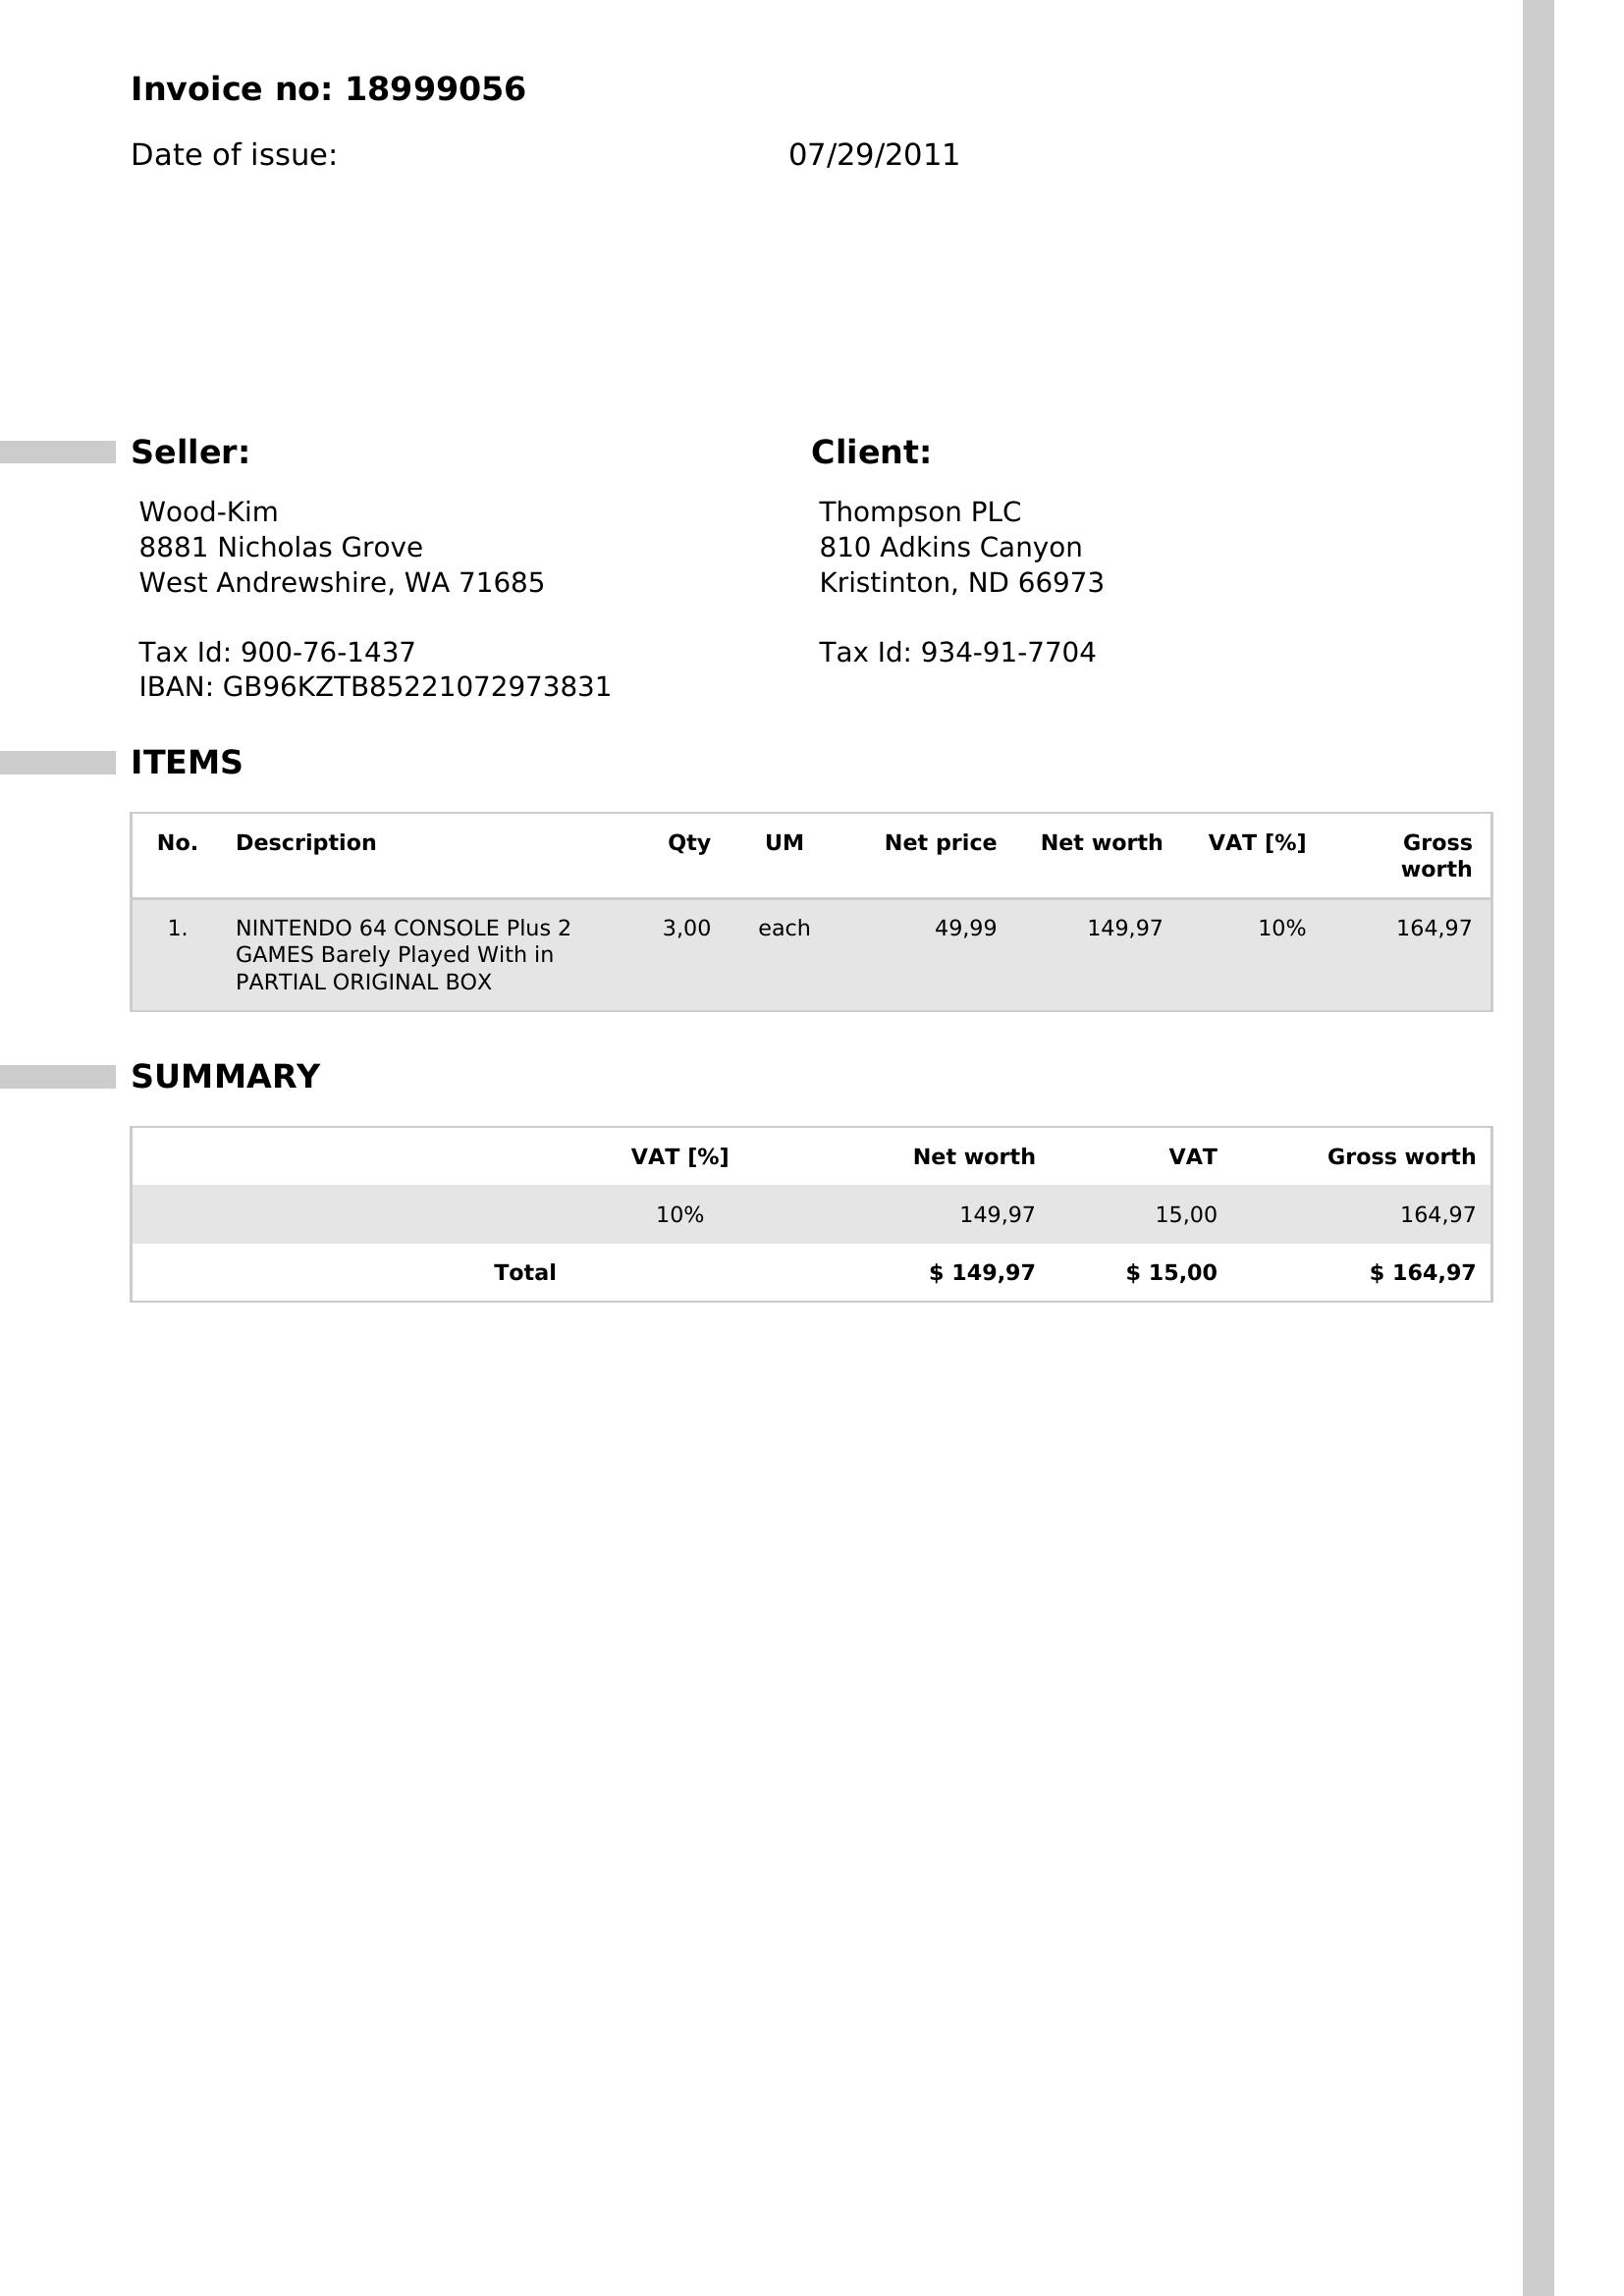

In [23]:
# get image
from transformers.image_utils import load_image
# img = load_image("./batch_1/batch_1/batch1_1/batch1-0002.jpg")

img = load_image("../batch_1/batch_1/batch1_2/batch1-0501.jpg") #from train data
img

In [24]:
# get prompts and images
messages_inference = [
    # {"role": "system", 
    #      "content": [{"type": "text", "text": system_message}]},
    {"role": "user", 
         "content": [{"type": "image", "image": img}, 
                     {"type": "text", "text": prompt_a}]},
]
text_input = processor.apply_chat_template(
    messages_inference, add_generation_prompt=True )

In [25]:
#set eval mode
model.eval()

# Prepare the inputs for the model
model_inputs = processor(
                        text=[text_input],
                        images=[img],
                        return_tensors="pt",
                        ).to("cuda")  

# Generate text with the model
generated_ids = model.generate(**model_inputs, max_new_tokens=600)

# Trim the generated ids to remove the input ids
trimmed_generated_ids = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(model_inputs.input_ids, generated_ids)]

# Decode the output text
output_text = processor.batch_decode(
    trimmed_generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False
)

print(output_text[0])

 {"client_address": "810 Adkins Canyon\nKristinton, ND 66973", "client_name": "Thompson PLC", "discount": "", "invoice_date": "07/29/2011", "invoice_number": "18999056", "seller_address": "8881 Nicholas Grove\nWest Andrewshire, WA 71685", "seller_name": "Wood-Kim", "tax": "15.00", "total": "164.97"}


In [165]:
messages_inference[0]

{'role': 'user',
 'content': [{'type': 'image',
   'image': <PIL.Image.Image image mode=RGB size=1654x2339>},
  {'type': 'text',
   'text': '\nYou are an intelligent invoice parser. From the provided invoice imag, extract the following structured information and return it in valid JSON format. \nFollow the descriptions and formatting guidelines for each field exactly. \n\nField Descriptions and Format Requirements:\n\nclient_name: The full name of the client (person or company) to whom the invoice is issued. Must be a single string without extra labels like "Bill To" or "Client:".\nclient_address: The complete mailing address of the client. It may span multiple lines. Include line breaks as \n. Remove any label like "Address:" or "Client Address:".\nseller_name: The full name of the seller or vendor (person or company) issuing the invoice. A single string only.\nseller_address: The full address of the seller. It may span multiple lines. Include line breaks as \n.\ninvoice_number: A uni

time: 2.06 ms (started: 2025-06-10 18:08:52 +00:00)
